In [1]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 10.4 MB/s eta 0:00:0000:01


In [2]:
import PIL.Image
import random
import torch
import torch.utils.data
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision import models
import torchvision.transforms as original_transforms
import torchvision.transforms.v2 as transforms
from torchvision.transforms.v2 import functional as F
from torchvision.utils import draw_bounding_boxes
import multiprocessing as mp
from torch import nn
import torch.optim as optim
from tqdm import tqdm

In [3]:
n_gpus = torch.cuda.device_count()
USING_CPU = not torch.cuda.is_available()

DEVICE = torch.device("cuda:0" if (torch.cuda.is_available()  and n_gpus > 0) else "cpu")
kwargs = {'num_workers': mp.cpu_count() , 'pin_memory': True} if DEVICE.type=='cuda' else {'num_workers': mp.cpu_count()//2, 'prefetch_factor': 4}


print(f'Num of CPUs: {mp.cpu_count()}')
print(f'Device in use: {DEVICE}')
print(f'Found {n_gpus} GPU Device/s.')

Num of CPUs: 4
Device in use: cpu
Found 0 GPU Device/s.


In [26]:
Train_Data = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
Annotation = '/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json'
USE_PRETRAINED = True
SAVED_MODEL_PATH = '/kaggle/working/checkpoint'

def load_dataset(transform):
    return dset.CocoDetection(root = Train_Data, 
                              annFile = Annotation)

In [5]:
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
        self.hf = transforms.RandomHorizontalFlip(1)
        
    def __call__(self, img, bboxes):
        
        if torch.rand(1)[0] < self.p:            
            img = self.hf.forward(img)
            bboxes = self.hf.forward(bboxes)
        
        return img, bboxes
    
    
class RandomVerticalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
        self.vf = transforms.RandomVerticalFlip(1)
        
    def __call__(self, img, bboxes):
        if torch.rand(1)[0] < self.p:                    
            img = self.vf.forward(img)
            bboxes = self.vf.forward(bboxes)
        
        return img, bboxes

class Resize(object):
    def __init__(self, size):
        self.size = size
        self.resize = transforms.Resize(self.size, antialias=True)
        
    def __call__(self, img, bboxes):
        img = self.resize.forward(img)
        bboxes = self.resize.forward(bboxes)
        return img, bboxes

In [6]:
def show(sample):
    import matplotlib.pyplot as plt
    from torchvision.transforms.v2 import functional as F
    from torchvision.utils import draw_bounding_boxes
    
    resize = Resize((300, 300))
    
    rhf = RandomHorizontalFlip()
    rvf = RandomVerticalFlip()
    image, target = sample
    
    image, bboxes = image,target["boxes"] 
    
    image, bboxes = resize(image, bboxes)
    image, bboxes = rhf(image, bboxes)
    image, bboxes = rvf(image, bboxes)
    
    if isinstance(image, PIL.Image.Image):
        image = F.to_tensor(image)
        
    image = F.convert_dtype(image, torch.uint8)
    annotated_image = draw_bounding_boxes(image, bboxes, colors="yellow", width=3)

    fig, ax = plt.subplots()
    ax.imshow(annotated_image.permute(1, 2, 0).numpy())
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    fig.tight_layout()

    fig.show()

In [7]:
transform = transforms.Compose(
    [
        transforms.RandomPhotometricDistort(),        
        transforms.RandomAutocontrast(),
        transforms.RandomEqualize(),
        transforms.GaussianBlur(kernel_size=3),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
    ]
)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
coco_train = load_dataset(transform=transform)
coco_train = dset.wrap_dataset_for_transforms_v2(coco_train)

loading annotations into memory...
Done (t=36.78s)
creating index...
index created!


In [9]:
class NewCocoDataset(Dataset):    
    def __init__(self, coco_dataset, image_size=(312, 312)):
        """
        Arguments:
            coco_dataset (dataset): The coco dataset containing all the expected transforms.
            image_size (tuple): Target image size. Default is (512, 512)
        """
        
        self.coco_dataset = coco_dataset
        self.resize = Resize(image_size)
        self.rhf = RandomHorizontalFlip()
        self.rvf = RandomVerticalFlip()   
        self.transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
        ])

        
    def __len__(self):
        return len(self.coco_dataset)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        new_target = {}
        
        image, target = self.coco_dataset[idx]
        
        if 'boxes' not in target:    
            new_idx = idx-1
            _img, _t = self.coco_dataset[new_idx]
            while 'boxes' not in _t :
                new_idx -= 1
                _img, _t = self.coco_dataset[new_idx]
                
            image, target = self.coco_dataset[new_idx]
        
        
        image, bboxes = image, target["boxes"] 
            
        image, bboxes = self.resize(image, bboxes)
        image, bboxes = self.rhf(image, bboxes)
        image, bboxes = self.rvf(image, bboxes)
        
        image = self.transformer(image)
        
        new_boxes = []
        for box in bboxes:
            if box[0] < box[2] and box[1] < box[3]:
                new_boxes.append(box)
        
        new_target["boxes"] = torch.stack(new_boxes)
        new_target["labels"] = target["labels"]
    
        return (image, new_target)

In [10]:
class CustomBatchs:
    def __init__(self, data):
        transposed_data = list(zip(*data))
        self.inp = torch.stack(transposed_data[0], 0)
        self.tgt = transposed_data[1]

    # custom memory pinning method on custom type
    def pin_memory(self):
        self.inp = self.inp.pin_memory()
        return (self.inp, self.tgt)
    
def collate_wrapper(batch):
    if torch.cuda.is_available():
        return CustomBatchs(batch)
    else:
        return tuple(zip(*batch))

In [11]:
new_coco_train = NewCocoDataset(coco_train)

data_loader = torch.utils.data.DataLoader(
    new_coco_train,
    batch_size=50 if not USING_CPU else 8,
    shuffle=True,
#     collate_fn=lambda batch: tuple(zip(*batch)),
    collate_fn=collate_wrapper,
     **kwargs
)

In [12]:
import pycocotools.coco

coco_anns = pycocotools.coco.COCO(Annotation)
catIDs = coco_anns.getCatIds()
cats = coco_anns.loadCats(catIDs)

name_idx = {}

for sub_dict in cats:
    name_idx[sub_dict["id"]] = sub_dict["name"]
    
del coco_anns, catIDs, cats

loading annotations into memory...
Done (t=39.94s)
creating index...
index created!


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([8, 3, 312, 312])


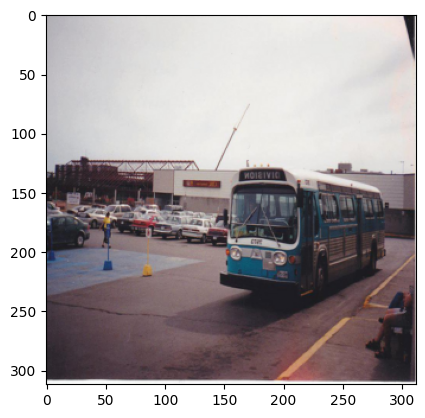

In [13]:
data = next(iter(data_loader))
if USING_CPU:
    x = torch.stack(data[0])
else:
    x = data[0]
print(x.shape)
# _labels = [name_idx[i] for i in data[1][0]['labels'].tolist()]
# print(_labels)

plt.imshow(data[0][0].permute(1, 2, 0).numpy())

In [21]:
base_model = models.get_model("ssd300_vgg16", weights=None, weights_backbone=None).train()

In [22]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [23]:
base_model.apply(weights_init)

if (DEVICE.type == 'cuda') and (n_gpus > 1):
    base_model = nn.DataParallel(base_model, list(range(n_gpus)))

In [24]:
base_model.to(DEVICE)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [18]:
learning_rate = 1e-4

optimizer = optim.Adam(base_model.parameters(), lr=learning_rate)

In [27]:
if USE_PRETRAINED:
    new_LR = 1e-5 # change this value to set a new Learning Rate for the version of notebook
    
    if USING_CPU:
        checkpoint = torch.load(SAVED_MODEL_PATH, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(SAVED_MODEL_PATH)
        
    base_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for g in optimizer.param_groups:
        g['lr'] = new_LR

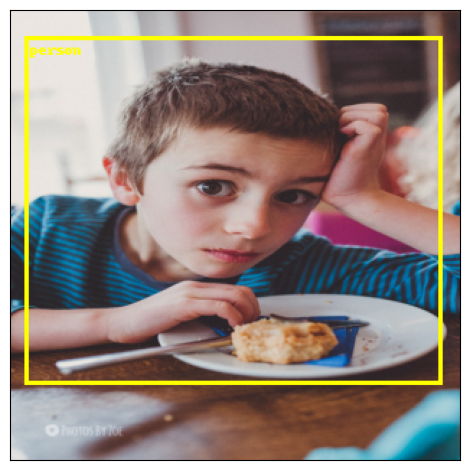

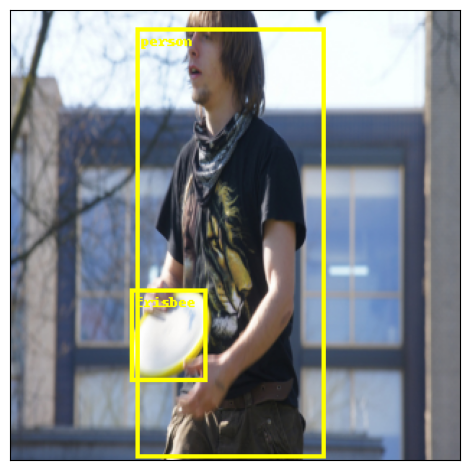

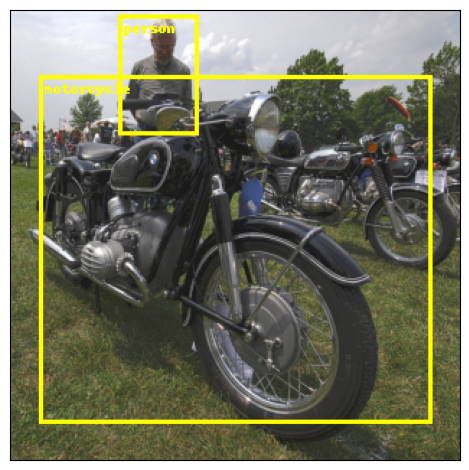

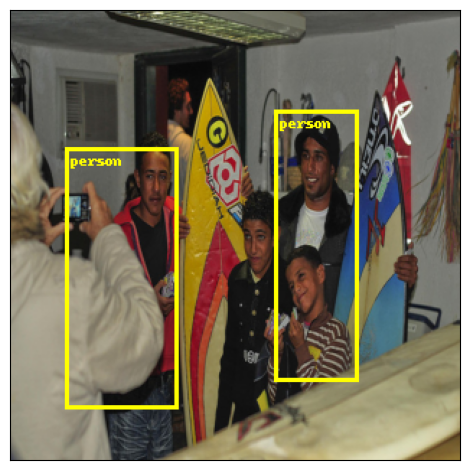

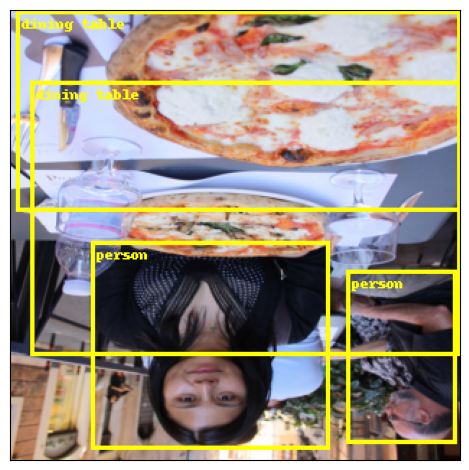

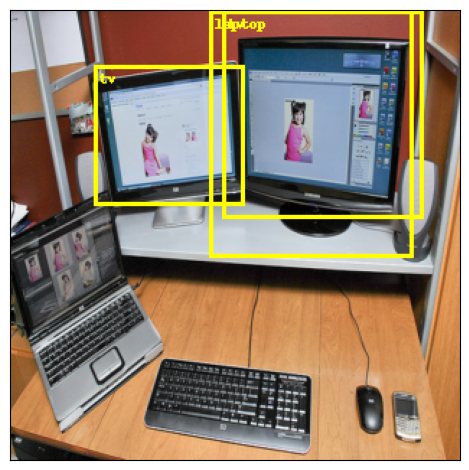

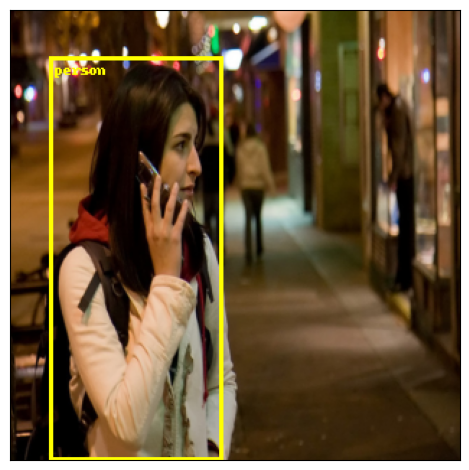

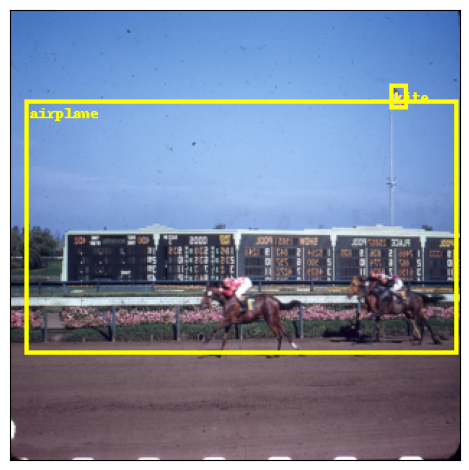

In [31]:
img_dtype_converter = transforms.ConvertImageDtype(torch.uint8)
data = next(iter(val_data_loader))

_i = data[0]

threshold = 0.3

if USING_CPU:
    _i = torch.stack(_i)

_i = _i.to(DEVICE)
base_model.eval()
p_t = base_model(_i)

indices = range(len(p_t))  # Choose all indices

for idx in indices:
    confidence_length = len(np.argwhere(p_t[idx]['scores'] > threshold)[0])

    p_boxes = p_t[idx]['boxes'][:confidence_length]
    p_labels = [name_idx[i] for i in p_t[idx]['labels'][:confidence_length].tolist()]
    i_img = img_dtype_converter(_i[idx])

    annotated_image = draw_bounding_boxes(i_img, p_boxes, p_labels, colors="yellow", width=3)
    fig, ax = plt.subplots()
    ax.imshow(annotated_image.permute(1, 2, 0).numpy())
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    fig.tight_layout()

    fig.show()

In [ ]:
EPOCHS = 5

In [ ]:
print(coco_train[10])
print(Dataset[10])

In [ ]:
print(data_loader[10])

In [ ]:
import gc
for epoch in range(EPOCHS):
    running_classifier_loss = 0.0
    running_bbox_loss = 0.0
    running_loss = 0.0
    
    counter = 0
    base_model.train()
    
    for data_point in tqdm(data_loader):
        _i, _t = data_point[0], data_point[1]
        
        if USING_CPU:
            _i = torch.stack(_i)

#         _t = torch.from_numpy(np.asarray(_t))
        
        _i = _i.to(DEVICE)
        _t = [{k: v.to(DEVICE) for k, v in __t.items()} for __t in _t]

        optimizer.zero_grad()


        loss_dict = base_model(_i, _t)
        
#         running_bbox_loss += torch.mean(loss_dict['bbox_regression']).item()
#         running_classifier_loss += torch.mean(loss_dict['classification']).item()

        losses = sum(loss for loss in loss_dict.values())
    
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()
        
        del loss_dict, losses
        
        counter += 1
        
        if counter % 500 == 499:
            last_classifier_loss = running_classifier_loss / 500 # loss per batch
            last_bbox_loss = running_bbox_loss / 500 # loss per batch
            last_loss = running_loss / 500 # loss per batch
#             print(f'batch {counter + 1} Classification Loss: {last_classifier_loss}', end='')
#             print(f', BBox Loss: {last_bbox_loss}')
            print(f'Epoch {epoch}, Batch {counter + 1}, Running Loss: {last_loss}')
            running_classifier_loss = 0.0
            running_bbox_loss = 0.0
            running_loss = 0.0
            
        gc.collect()

In [ ]:
import gc
gc.collect()

In [30]:
VAL_IMG_DIR = '/kaggle/input/coco-2017-dataset/coco2017/val2017'
VAL_ANN_FILE = '/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json'


def load_val_dataset(transform):
    return dset.CocoDetection(root = VAL_IMG_DIR, 
                              annFile = VAL_ANN_FILE)

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
    ]
)
coco_val = load_val_dataset(transform=val_transform)
coco_val = dset.wrap_dataset_for_transforms_v2(coco_val)

new_coco_val = NewCocoDataset(coco_val)
val_data_loader = torch.utils.data.DataLoader(
    new_coco_val,
    batch_size=50 if not USING_CPU else 8,
    shuffle=True,
#     collate_fn=lambda batch: tuple(zip(*batch)),
    collate_fn=collate_wrapper,
     **kwargs
)

loading annotations into memory...
Done (t=1.21s)
creating index...
index created!


In [19]:
PATH = '/kaggle/working/checkpoint'

In [20]:
checkpoint = torch.load(PATH)
base_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomPhotometricDistort(),        
        transforms.RandomAutocontrast(),
        transforms.RandomEqualize(),
        transforms.GaussianBlur(kernel_size=3),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
    ]

In [35]:
from PIL import Image

# Assuming you've already defined the `transform` function

# Load the image
image = Image.open('/kaggle/input/my-pic/IMG_7468.PNG')
input_tensor = transform(image).to(DEVICE)  # Move input tensor to the GPU
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

# Ensure the model is in evaluation mode
base_model.eval()

# Perform inference
with torch.no_grad():
    output = base_model(input_batch)


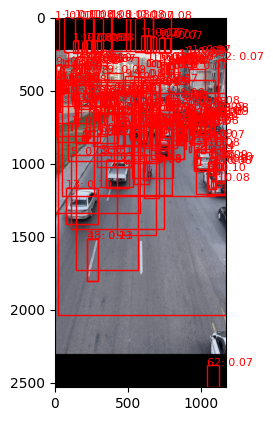

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Assuming `output` contains the predictions from your model

# Iterate over each output in the list
for output_item in output:
    # Convert the output tensor to numpy arrays
    boxes = output_item['boxes'].cpu().numpy()
    labels = output_item['labels'].cpu().numpy()
    scores = output_item['scores'].cpu().numpy()

    # Load the original image
    image = Image.open('/kaggle/input/my-pic/IMG_7468.PNG')

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Plot each bounding box with its label and score
    for box, label, score in zip(boxes, labels, scores):
        # Extract coordinates
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the plot
        ax.add_patch(rect)

        # Add label and score
        ax.text(x_min, y_min, f'{label}: {score:.2f}', fontsize=8, color='r')

    # Show the plot
    plt.show()


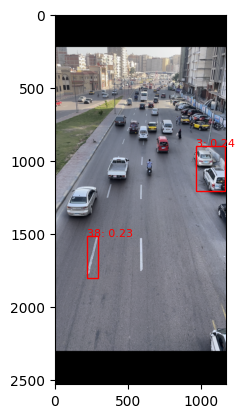

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Assuming `output` contains the predictions from your model

# Define a threshold for confidence scores
threshold = 0.2 # Adjust this threshold as needed

# Iterate over each output in the list
for output_item in output:
    # Convert the output tensor to numpy arrays
    boxes = output_item['boxes'].cpu().numpy()
    labels = output_item['labels'].cpu().numpy()
    scores = output_item['scores'].cpu().numpy()

    # Load the original image
    image = Image.open('/kaggle/input/my-pic/IMG_7468.PNG')

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Plot each bounding box with its label and score if score is above the threshold
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            # Extract coordinates
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min

            # Create a rectangle patch
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')

            # Add the patch to the plot
            ax.add_patch(rect)

            # Add label and score
            ax.text(x_min, y_min, f'{label}: {score:.2f}', fontsize=8, color='r')

    # Show the plot
    plt.show()


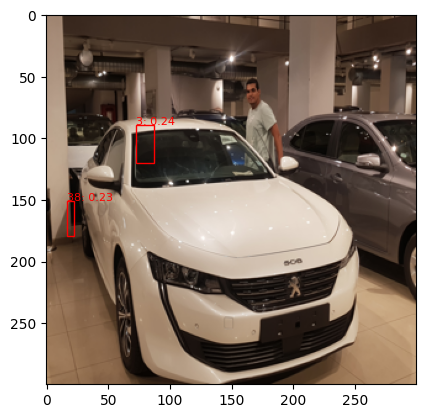

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

target_size = (300, 300) 

for output_item in output:
    # Convert the output tensor to numpy arrays
    boxes = output_item['boxes'].cpu().numpy()
    labels = output_item['labels'].cpu().numpy()
    scores = output_item['scores'].cpu().numpy()

    # Load the original image
    image = Image.open('/kaggle/input/my-pic/20190919_223034.JPG')

    # Resize the image
    resized_image = image.resize(target_size)

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Display the resized image
    ax.imshow(resized_image)

    # Get the scaling factors for the bounding box coordinates
    scale_x = target_size[0] / image.width
    scale_y = target_size[1] / image.height

    # Plot each bounding box with its label and score if score is above the threshold
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            # Extract coordinates
            x_min, y_min, x_max, y_max = box

            # Rescale bounding box coordinates
            x_min *= scale_x
            x_max *= scale_x
            y_min *= scale_y
            y_max *= scale_y

            # Calculate width and height
            width = x_max - x_min
            height = y_max - y_min

            # Create a rectangle patch
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')

            # Add the patch to the plot
            ax.add_patch(rect)

            # Add label and score
            ax.text(x_min, y_min, f'{label}: {score:.2f}', fontsize=8, color='r')

    # Show the plot
    plt.show()


In [40]:
# Perform inference with the model
with torch.no_grad():
    output = base_model([resized_image_tensor.squeeze(0)])

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the resized image
ax.imshow(resized_image)

# Get the scaling factors for the bounding box coordinates
scale_x = resized_image.size[0] / image.width
scale_y = resized_image.size[1] / image.height

# Plot each bounding box with its label and score if score is above the threshold
for box, label, score in zip(output[0]['boxes'], output[0]['labels'], output[0]['scores']):
    if score >= threshold:
        # Extract coordinates
        x_min, y_min, x_max, y_max = box.cpu().numpy()

        # Rescale bounding box coordinates
        x_min *= scale_x
        x_max *= scale_x
        y_min *= scale_y
        y_max *= scale_y

        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min

        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the plot
        ax.add_patch(rect)

        # Add label and score
        ax.text(x_min, y_min, f'{label.item()}: {score.item():.2f}', fontsize=8, color='r')

# Show the plot
plt.show()


NameError: name 'resized_image_tensor' is not defined

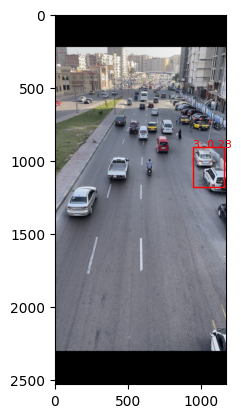

In [41]:
# Move the input tensor to the same device as the model's weights


image = Image.open('/kaggle/input/my-pic/IMG_7468.PNG')
image_tensor = transform(image).to(next(base_model.parameters()).device)

# Perform inference with the model
with torch.no_grad():
    output = base_model([image_tensor])

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the original image
ax.imshow(image)

# Plot each bounding box with its label and score if score is above the threshold
for box, label, score in zip(output[0]['boxes'], output[0]['labels'], output[0]['scores']):
    if score >= threshold:
        # Extract coordinates
        x_min, y_min, x_max, y_max = box.cpu().numpy()

        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min

        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the plot
        ax.add_patch(rect)

        # Add label and score
        ax.text(x_min, y_min, f'{label.item()}: {score.item():.2f}', fontsize=8, color='r')

# Show the plot
plt.show()




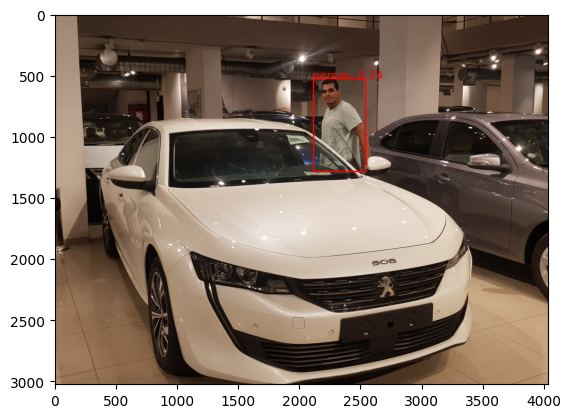

In [42]:
# Move the input tensor to the same device as the model's weights
image = Image.open('/kaggle/input/my-pic/20190919_223034.JPG')
image_tensor = transform(image).to(next(base_model.parameters()).device)

base_model.eval()
# Perform inference with the model
with torch.no_grad():
    output = base_model([image_tensor])

# Get original labels from COCO dataset
labels = [name_idx[label.item()] for label in output[0]['labels']]

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the original image
ax.imshow(image)

# Plot each bounding box with its label and score if score is above the threshold
for box, label, score in zip(output[0]['boxes'], labels, output[0]['scores']):
    if score >= threshold:
        # Extract coordinates
        x_min, y_min, x_max, y_max = box.cpu().numpy()

        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min

        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the plot
        ax.add_patch(rect)

        # Add label and score
        ax.text(x_min, y_min, f'{label}: {score.item():.2f}', fontsize=8, color='r')

# Show the plot
plt.show()


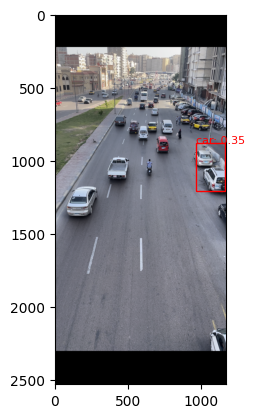

In [43]:
# Move the input tensor to the same device as the model's weights
image = Image.open('/kaggle/input/my-pic/IMG_7468.PNG')
image_tensor = transform(image).to(next(base_model.parameters()).device)

base_model.eval()
# Perform inference with the model
with torch.no_grad():
    output = base_model([image_tensor])

# Get original labels from COCO dataset
labels = [name_idx[label.item()] for label in output[0]['labels']]

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the original image
ax.imshow(image)

# Plot each bounding box with its label and score if score is above the threshold
for box, label, score in zip(output[0]['boxes'], labels, output[0]['scores']):
    if score >= threshold:
        # Extract coordinates
        x_min, y_min, x_max, y_max = box.cpu().numpy()

        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min

        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the plot
        ax.add_patch(rect)

        # Add label and score
        ax.text(x_min, y_min, f'{label}: {score.item():.2f}', fontsize=8, color='r')

# Show the plot
plt.show()
